In [1]:
%%capture
!pip install pyspark_dist_explore
!pip install -q kaggle

In [2]:
# Work With Files
from google.cloud import storage
import os

# Useful libraries:
from time import time
import numpy as np
import pandas as pd
import math
from functools import reduce

# To Plot:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark_dist_explore import hist

# Pyspark Lib:
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import col
import pyspark.sql.functions as F
from pyspark import SparkContext, SparkConf

# Preprocess:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import MinMaxScaler

# Pysparl ML:
from pyspark.ml.regression import LinearRegression

In [3]:
PATH_BUCKET = 'gs://nyc_comp_bk/'
PATH_DATA = '/home/ubuntu/NYC_Taxi/data/'

In [4]:
os.chdir('/home/ubuntu/NYC_Taxi/')

In [5]:
class Work_On_Bucket():
    
    def __init__(self, bucket_name):
        # Get access to the bucket:
        storage_client = storage.Client()
        self.bucket = storage_client.get_bucket(bucket_name)
        
    def get_file_from_bucket(self, file_name, save_path):
        # Download the file:
        blob = self.bucket.blob(file_name)
        blob.download_to_filename(''.join([save_path, file_name]))
            
    def upload_file_to_bucket(self, file_name, folder_path):
        # Upload the File
        object_to_save = self.bucket.blob(file_name)
        object_to_save.upload_from_filename(folder_path + file_name)


### Get the Dataset:

In [6]:
Bucket = Work_On_Bucket('nyc_comp_bk')

In [7]:
# Set kaggle:
! mkdir ~/.kaggle
Bucket.get_file_from_bucket('kaggle.json', '/home/ubuntu/NYC_Taxi/')
! cp /home/ubuntu/NYC_Taxi/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
# Download The Dataset
!kaggle competitions download -c new-york-city-taxi-fare-prediction

# Unzip the Files
! unzip new-york-city-taxi-fare-prediction.zip -d /home/ubuntu/NYC_Taxi/data/
! rm new-york-city-taxi-fare-prediction.zip

# Upload databses to bucket:
print('Start Uploding!')
Bucket.upload_file_to_bucket('train.csv', PATH_DATA)
Bucket.upload_file_to_bucket('test.csv', PATH_DATA)
print('Succesfully Uploaded!')

100%|██████████████████████████████████████▉| 1.56G/1.56G [00:16<00:00, 128MB/s]
100%|███████████████████████████████████████| 1.56G/1.56G [00:16<00:00, 104MB/s]
Archive:  new-york-city-taxi-fare-prediction.zip
  inflating: /home/ubuntu/NYC_Taxi/data/GCP-Coupons-Instructions.rtf  
  inflating: /home/ubuntu/NYC_Taxi/data/sample_submission.csv  
  inflating: /home/ubuntu/NYC_Taxi/data/test.csv  
  inflating: /home/ubuntu/NYC_Taxi/data/train.csv  
Start Uploding!
Succesfully Uploaded!


### Preliminary Steps (Load + Checks):

In [8]:
# Load Data:
train = spark.read.load(PATH_BUCKET+"train.csv", format="csv", inferSchema="true", header="true")
test = spark.read.load(PATH_BUCKET+"test.csv", format="csv", inferSchema="true", header="true")

# Load Test (Because pyspark changes the timestamp):
Bucket.get_file_from_bucket('test.csv', '')
original_test = pd.read_csv('test.csv')

In [9]:
# Get DB shape:
ncol = len(train.columns)
nrow = train.count()
print("The shape of the dataset is {:d} rows by {:d} columns".format(nrow, ncol))

The shape of the dataset is 55423856 rows by 8 columns


In [10]:
# Get the schema:
train.printSchema()

root
 |-- key: timestamp (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: integer (nullable = true)



In [9]:
# Remove Key, not needed:
train = train.drop('key')

In [11]:
# Show some basic Statistics:
stats = train.select(train.columns[1:]).describe()
stats.toPandas()

,summary,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,count,55423856,55423856,55423856,55423856,55423480,55423480,55423856
1,mean,11.345045601663855,None,-72.50968444358728,39.91979178688818,-72.5112097297181,39.92068144482884,1.6853799201556816
2,stddev,20.7108321982325,None,12.848883381402654,9.642353041994934,12.782196517830771,9.633345796415126,1.327664357095968
3,min,-300.0,2009-01-01 00:00:27 UTC,-3442.059565,-3492.263768,-3442.024565,-3547.886698,0
4,max,93963.36,2015-06-30 23:59:54 UTC,3457.625683,3408.789565,3457.62235,3537.132528,208


In [12]:
# Check Nulls:
for c in train.columns[2:]:
    nans = train.where(col(c).isNull()).count()
    print('{:s}: {:d}'.format(c, nans))

pickup_datetime: 0
pickup_longitude: 0
pickup_latitude: 0
dropoff_longitude: 376
dropoff_latitude: 376
passenger_count: 0


In [10]:
# Remove Rows with Missing Values:
train = train.na.drop(how='any')

In [14]:
# Check Duplicates:
print('The Duplicates are: {:d}'.format(train.count()-train.distinct().count()))

The Duplicates are: 1650


In [11]:
# Remove Duplicates:
train = train.distinct()

### Create My Base Line:

As Base Line I am going to use a Multiple Linear Regression that takes as input all the scaled (mean=0, sd=1) numerical variables.
As result I get an RMSE = 9.40719 on the Test.

In [23]:
NUMERICAL = ['pickup_longitude',
            'pickup_latitude',
            'dropoff_longitude',
            'dropoff_latitude',
            'passenger_count']
TARGET = 'fare_amount'

In [24]:
# Get the feature Vector:
assembler = VectorAssembler(inputCols=NUMERICAL, outputCol="features")
train_df = assembler.transform(train.filter('fare_amount > 2.50 AND fare_amount < 1000'))
train_df = train_df.select('features', TARGET)

In [25]:
# Scale Data:
scaler = StandardScaler(inputCol="features", outputCol="ScaledFeatures")
scalerModel = scaler.fit(train_df)
train_df = scalerModel.transform(train_df)
train_df = train_df.select('ScaledFeatures', TARGET)

In [26]:
# Run the Linear Regression:
lr = LinearRegression(featuresCol="ScaledFeatures", labelCol=TARGET, maxIter=10)
lr_model = lr.fit(train_df)

# Print Stats:
training_result = lr_model.summary
print("***** Training Set *****")
print("RMSE: {:.3f}".format(training_result.rootMeanSquaredError))
print("MAE: {:.3f}".format(training_result.meanAbsoluteError))
print("R2: {:.3f}".format(training_result.r2))
print("***** Training Set *****")

***** Training Set *****
RMSE: 9.792
MAE: 6.030
R2: 0.000
***** Training Set *****


In [27]:
# Prepare the test:
test_df = assembler.transform(test.select(NUMERICAL))
test_df = test_df.select('features')
test_df = scalerModel.transform(test_df)

# Make Predictions:
predictions = lr_model.transform(test_df).select('prediction').withColumnRenamed('prediction','fare_amount').toPandas()

# Prepare the Submission:
submission = pd.concat([original_test['key'], predictions['fare_amount']], axis=1)
submission.to_csv('submission.csv', index=False)

# Submit:
!kaggle competitions submit -c new-york-city-taxi-fare-prediction -f submission.csv -m "First Submission"
!kaggle competitions submissions -c new-york-city-taxi-fare-prediction

fileName        date                 description       status    publicScore  privateScore  
--------------  -------------------  ----------------  --------  -----------  ------------  
submission.csv  2021-06-26 11:42:04  First Submission  complete  9.40719      9.40719       
submission.csv  2021-06-23 15:15:57  First Submission  complete  9.40712      9.40712       
submission.csv  2021-06-23 15:10:56  First Submission  complete  9.40712      9.40712       
submission.csv  2021-06-23 14:58:58  None              error     None         None          
submission.csv  2021-06-23 14:58:06  First Submission  error     None         None          
submission.csv  2021-06-23 14:55:46  None              error     None         None          
submission.csv  2021-06-23 14:54:33  First Submission  error     None         None          
submission.csv  2021-06-23 14:52:36  None              error     None         None          
submission.csv  2021-06-23 14:51:55  First Submission  error     None 

### EDA

#### 1) Latitude and Longitude

From the study of the quantiles it is clear that there are many outlayers, because the NYC coordinates are (lat=40.730610 lon=-73.935242). Even working with quantiles, removing anything out of the I and III quartile things don't change so much. Therefore, I opt for anothe option, I draw a triangle around the area of interest, a triangle because NY City is on an icleand which reminds a triangle, but the area is bigger than the iceland, to take into acocunt possible trips from the countriside. Everything outside the triangle will be dropped. In order to have a more permissive approach, it is possible to draw a rectangle and include more points: It seems that there are many taxis that go and come from/to the states placed at the North of NYC. To decide whether a point is in the triangle I walk clockwise or counterclockwise around the triangle and project the point onto the segment I am crossing by using the dot product. Finally, I check that the vector created is on the same side for each of the triangle's segments.
There is another issues linked with the coordinates, there are some points (both for pick up and drop off) which are located in the ocean, There are different libraries that can help in remving them, by masking the map, but it takes too much computational resources. Another possibility is to define a more complex shape (instead of a triangle) that defines bounderies more accurately, but this option is too expensive in terms of computation, too (no easy way to compute if a point is in a complex geometric figure). Not having any alternatives I keep them hopping that they won't affect my model too much. 
For what concerns how pick up and drop off locations are distributed in the map, as I expected they are mostly concentrated in Manhattan. Howevere, there are two areas outside it, which seems to have an important tarffic of Taxi: one is the JFK Airport and the other one is a point in Hamilton Town in New Jersy. In addition, it is possible to check that drop off locations are more spread all along NYC than pickup ones that are more concentrated in Manhattan. For what concerns the avarage fare amount for a trip, it seems to increase the further the trip ends outised Mantthan and if a trip start or stop from/in the JFK airport, but here also the time variables play a role (let's see in the next part). Finally, it seems that some trips are repeted more frequently, the mode is 1, but for some observations the count can arrive up to 36 (and potentially more, for the full dataset). This suggest me that there are some people tha use it regularly, they may get a discount for that reason, a kind of subscription. Given that they are very few, for the moment I am not going to create a variable ad hoc (taking also into account that the data are spread over 6 years, 36 times is not such a significant amount).


The it is possible to compute new features that can be useful both for the model and to remove more outlayers, namely the Absolute Distance, the Haversinee Distance and the Minkowski Distance (that for p=1 is the Manhattan and for p=2 is the Euclidean distance). All the distances are expressed in kilometers. To obtain some of them I need to know to how much km corresponds the variation of 1 degree for each coordinates and it turns put that for Latitude it is 111 Km and for Longitude is 85 Km. Checking the statistics of th emetrics it is clear that there are many outlayers. To drop them I am going to use a kind of voting, for each observation I get the mean of manhattan, euclidean and haversine distances metrics and remove the observation if its distance mean is less than 0.5 (namel less than 500m trip).

Another feature that can improve my model is the direction (in degree) of the trip. Because the computed distancem is only an approximation and o the angle can improve this approximation. To comput the distance I use the Bearing Algorithm and I multiply the result by -1 because of the negative longitude.

Exploiting the function to compute the haversian distance (which is the more realistic) I compute the distanes from the airports, both for pick up and drop off and I create a column that says whether the pick up or dorp off happened near by the airport. It is possible that there the costs are higher or maybe fixed. It is possible to check using a groupby that the average price is far away higher than the one for a standard trip. Furthermore, for rhe most of them the standard deviation shows that maybe the prices are not fixed or anyway that the prices can change up to +/-30$ for the most volatile airport (EWR).

Then I suppose that a there must be a relationship between fear amount and length of the trip (it maybe also connected with duration). Hence, I create a variable tha distinguish among trips under the mean and over the mean. It seems that my hypothesis is confirmed.

In [12]:
# Check I, II and III Quantiles:
np.array([train.approxQuantile('pickup_longitude', [0.25, 0.50, 0.75], 0.25),
          train.approxQuantile('pickup_latitude', [0.25, 0.50, 0.75], 0.25),
          train.approxQuantile('dropoff_longitude', [0.25, 0.50, 0.75], 0.25),
          train.approxQuantile('dropoff_latitude', [0.25, 0.50, 0.75], 0.25)])

array([[-3442.059565,  2123.82246 ,  3457.625683],
       [-3492.263768,   444.133332,  3408.789565],
       [-3442.024565,   -73.980088,  3457.62235 ],
       [-3547.886698,  2599.28739 ,  3537.132528]])

In [13]:
# Write function to check if a point is a triangle:

def point_in_triangle(lat, long):
    """
    phuclv (https://stackoverflow.com/questions/2049582/how-to-determine-if-a-point-is-in-a-2d-triangle)
    To decide whether a point is in the triangle walk clockwise or counterclockwise around the triangle and 
    project the point onto the segment crossing by using the dot product. 
    Finally, check that the vector created is on the same side for each of the triangle's segments.
    
    Parameters
    ----------
    lat : float
        The latitude coordinate of a point
    long :float
        The longitude oordinate of a point

    Returns
    -------
    bool
        whether all signs of the sides are positive/negative
    """
    # Unpack arguments
    x = lat
    y = long
    ax, ay = (39.74274655286439, -75.26399018397262)
    bx, by = (41.58840050439113, -75.18708588709761)
    cx, cy = (41.07279488244855, -71.76484467616011)
    # Segment A to B
    side_1 = (x - bx) * (ay - by) - (ax - bx) * (y - by)
    # Segment B to C
    side_2 = (x - cx) * (by - cy) - (bx - cx) * (y - cy)
    # Segment C to A
    side_3 = (x - ax) * (cy - ay) - (cx - ax) * (y - ay)
    # All the signs must be positive or all negative
    return (side_1 < 0.0) == (side_2 < 0.0) == (side_3 < 0.0)

def is_in_area(lat1, lon1, lat2, lon2):
    
    """
    
    Check whether both pick up and drop off points of an observation
    are in the triangle.
    
    Parameters
    ----------
    lat1 : float
        The latitude coordinate of a pick up point
    long1 :float
        The longitude oordinate of a pick up point
        
    lat2 : float
        The latitude coordinate of a drop off point
    long2 :float
        The longitude oordinate of a drop off point

    Returns
    -------
    bool
        whether both the points are in the hotspot
    """
    
    pick = point_in_triangle(lat1, lon1)
    drop = point_in_triangle(lat2, lon2)
    
    return all([pick, drop])

is_in_area_udf = F.udf(is_in_area, BooleanType())

In [14]:
# Remove any point outside the given area:
train = train.withColumn('keep', is_in_area_udf( col('pickup_latitude'), col('pickup_longitude'), col('dropoff_latitude'), col('dropoff_longitude') ) )
train = train.filter("keep == True")
train = train.drop('keep')

In [15]:
train.select(col('pickup_latitude'), col('pickup_longitude'), col('dropoff_latitude'), col('dropoff_longitude')).describe().show()

+-------+--------------------+-------------------+-------------------+--------------------+
|summary|     pickup_latitude|   pickup_longitude|   dropoff_latitude|   dropoff_longitude|
+-------+--------------------+-------------------+-------------------+--------------------+
|  count|            54235168|           54235168|           54235168|            54235168|
|   mean|   40.75084046363401| -73.97546359704323|  40.75123945667267|  -73.97456012998938|
| stddev|0.027549044484391723|0.03574727580738844|0.03143901853685563|0.035618188092662054|
|    min|           39.804188| -75.25401306152344|           39.80016|  -75.25403594970703|
|    max|           41.519495|           -72.0619|          41.567147|           -71.97642|
+-------+--------------------+-------------------+-------------------+--------------------+



In [16]:
# Write Functions needed to Create Coordinates Features

class Coordinates_Transform():

    def __init__(self, df):

        self.df = df
        self.haversine_udf = F.udf(Coordinates_Transform.haversine_stat, DoubleType())
        self.direction_udf = F.udf(Coordinates_Transform.calculate_dir, DoubleType())
        self.airports_udf = F.udf(Coordinates_Transform.identify_airports, StringType())


    @staticmethod
    def haversine_stat(pick_lat, drop_lat, pick_long, drop_long):

        longit_a, latit_a, longit_b, latit_b = map(math.radians, [pick_long,  pick_lat, drop_long, drop_lat])
        dist_longit = longit_b - longit_a
        dist_latit = latit_b - latit_a
        # Calculate area
        area = math.sin(dist_latit/2)**2 + math.cos(latit_a) * math.cos(latit_b) * math.sin(dist_longit/2)**2
        # Calculate the central angle
        central_angle = 2 * math.asin(math.sqrt(area))
        RADIUS = 6371
        # Calculate Distance
        distance = central_angle * RADIUS
        return round(distance, 3)

    def add_dist_metrics(self):
       
        # Absolute Lat e Long Distance:
        self.df = self.df.withColumn( 'abs_dist_longitude', F.round( F.abs( col('pickup_longitude') - col('dropoff_longitude') ) * 85, 3 ) )
        self.df = self.df.withColumn( 'abs_dist_latitude', F.round( F.abs( col('pickup_latitude') - col('dropoff_latitude') ) * 111 , 3 ) )

        # Manhattan Distance:
        self.df = self.df.withColumn( 'manhattan_dist', F.round( col('abs_dist_longitude') + col('abs_dist_latitude'), 3 ) )

        # Euclidean Distance:
        self.df = self.df.withColumn( 'euclidean_dist',  F.round( F.sqrt( col('abs_dist_longitude')**2 + col('abs_dist_latitude')**2 ), 3 ) )

        # Haversine Distance:
        self.df = self.df.withColumn( 'haversine_dist', 
                                     self.haversine_udf( col('pickup_latitude'), col('dropoff_latitude'), col('pickup_longitude'), col('dropoff_longitude') ) ) 

        return self.df

    @staticmethod
    def calculate_dir(lat1, lon1, lat2, lon2):

        '''
        https://www.movable-type.co.uk/scripts/latlong.html
        It is measured in 0 - 360 degrees
        '''

        dlon = lon2 - lon1
        y = math.sin(dlon) * math.cos(lat2)
        x = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(dlon)
        theta = math.atan2(y, x)*180/math.pi

        return (-theta + 360) % 360



    def direction(self):
        self.df = self.df.withColumn('direction', self.direction_udf( col('pickup_latitude'), col('pickup_longitude'), col('dropoff_latitude'), col('dropoff_longitude') ))
        return self.df

    def third_dim_remap(self):
        '''
        The credit for the next features goes to Jan van der Vegt @datascience.stackexchange.com
        https://datascience.stackexchange.com/users/14904/jan-van-der-vegt
        '''
        # Compute coordinates for pickup:
        self.df = self.df.withColumn('pickup_x', F.cos('pickup_latitude') * F.cos('pickup_longitude'))
        self.df = self.df.withColumn('pickup_y', F.cos('pickup_latitude') * F.sin('pickup_longitude'))
        self.df = self.df.withColumn('pickup_z', F.sin('pickup_latitude'))

        # Compute coordinates for dropoff
        self.df = self.df.withColumn('dropoff_x', F.cos('dropoff_latitude') * F.cos('dropoff_longitude'))
        self.df = self.df.withColumn('dropoff_y', F.cos('dropoff_latitude') * F.sin('dropoff_longitude'))
        self.df = self.df.withColumn('dropoff_z', F.sin('dropoff_latitude'))

        return self.df


    @staticmethod
    def identify_airports(pick_lat, drop_lat, pick_long, drop_long):

        # Set the coordinates of airports:
        JFK_LAT = 40.641766
        JFK_LON = -73.780968

        LGR_LAT = 40.773013
        LGR_LON = -73.870229

        EWR_LAT = 40.689531
        EWR_LON = -74.174462

        # Compute distances:
        pick_up_jfk = Coordinates_Transform.haversine_stat(JFK_LAT, pick_lat, JFK_LON, pick_long)
        drop_off_jfk = Coordinates_Transform.haversine_stat(drop_lat, JFK_LAT, drop_long, JFK_LON)

        pick_up_lgr = Coordinates_Transform.haversine_stat(LGR_LAT, pick_lat, LGR_LON, pick_long)
        drop_off_lgr = Coordinates_Transform.haversine_stat(drop_lat, LGR_LAT, drop_long, LGR_LON)

        pick_up_ewr = Coordinates_Transform.haversine_stat(EWR_LAT, pick_lat, EWR_LON, pick_long)
        drop_off_ewr = Coordinates_Transform.haversine_stat(drop_lat, EWR_LAT, drop_long, EWR_LON)

        print(pick_up_jfk, drop_off_jfk)
        # Assign a value:
        if pick_up_jfk < 1:
            return 'PICK_JFK'
        elif drop_off_jfk < 1:
            return 'DROP_JFK'
        if pick_up_lgr < 1:
            return 'PICK_LGR'
        elif drop_off_lgr < 1:
            return 'DROP_LGR'
        if pick_up_ewr < 1:
            return 'PICK_EWR'
        elif drop_off_ewr < 1:
            return 'DROP_EWR'
        else:
            return 'NO_AIRPORT'

    def airports(self):

        self.df = self.df.withColumn('airport', 
                                     self.airports_udf( col('pickup_latitude'), col('dropoff_latitude'), col('pickup_longitude'), col('dropoff_longitude') ))
        return self.df

    def long_short_trip(self):

        mean_len = self.df.select('haversine_dist').agg(F.mean(col('haversine_dist'))).first()[0]
        self.df = self.df.withColumn( 'long_short', F.when(col('haversine_dist') <= mean_len, 'short') \
                                     .otherwise('long') )
        return self.df



In [17]:
# Add Distance metrics:
coordTransform = Coordinates_Transform(train)
train = coordTransform.add_dist_metrics()

In [18]:
# Let's Check df:
train.select('abs_dist_longitude', 'abs_dist_latitude', 'manhattan_dist', 'euclidean_dist', 'haversine_dist').describe().toPandas()

,summary,abs_dist_longitude,abs_dist_latitude,manhattan_dist,euclidean_dist,haversine_dist
0,count,54235168,54235168,54235168,54235168,54235168
1,mean,1.9286066518499425,2.357046155476089,4.28565280732606,3.3246101278786595,3.315646530605393
2,stddev,2.887787858818069,2.5609968462258927,4.783709562936858,3.6221773285676875,3.607593005204814
3,min,0.0,0.0,0.0,0.0,0.0
4,max,158.809,128.346,210.365,163.92,162.283


In [19]:
# Let's remove outlayers:
DIST_METRICS = ['manhattan_dist', 'euclidean_dist', 'haversine_dist']
n = len(DIST_METRICS)
row_mean  = (sum(col(x) for x in DIST_METRICS) / n).alias("mean_dist")
train = train.where( (row_mean >= 0.5) )

In [20]:
train.select('abs_dist_longitude', 'abs_dist_latitude', 'manhattan_dist', 'euclidean_dist', 'haversine_dist').describe().toPandas()

,summary,abs_dist_longitude,abs_dist_latitude,manhattan_dist,euclidean_dist,haversine_dist
0,count,52277799,52277799,52277799,52277799,52277799
1,mean,1.9966080829072308,2.4408030829874807,4.437411165894727,3.4421882540617297,3.4329118362653372
2,stddev,2.919377212362032,2.5708288215629684,4.806322907125751,3.636923794344817,3.6221358994083372
3,min,0.0,0.0,0.5,0.44,0.438
4,max,158.809,128.346,210.365,163.92,162.283


In [21]:
# Add Directions:
train = coordTransform.direction()

In [22]:
# Add third dimension:
train = coordTransform.third_dim_remap()

In [23]:
# Let's Add when starting point or arrival is at the airport:
train = coordTransform.airports()

In [24]:
# Check avg price for the airports:
train.select('airport','fare_amount').groupBy('airport').agg(F.mean('fare_amount'), F.stddev('fare_amount'), F.count('fare_amount')).sort('avg(fare_amount)').show()

+----------+------------------+------------------------+------------------+
|   airport|  avg(fare_amount)|stddev_samp(fare_amount)|count(fare_amount)|
+----------+------------------+------------------------+------------------+
|NO_AIRPORT| 9.883849381264305|       20.12932370022055|          51425249|
|  PICK_LGR|30.539708546336954|       11.22933687200242|           1023456|
|  DROP_LGR|   31.290757161067|       7.472403972288996|            618204|
|  PICK_JFK| 44.04999031117295|      16.279093865880675|            778216|
|  DROP_JFK| 50.37918619737053|       8.240775868954858|            321417|
|  PICK_EWR| 65.20260009310988|       34.11488374875951|              4296|
|  DROP_EWR|  70.8729424840665|      14.005440984793118|             64330|
+----------+------------------+------------------------+------------------+



In [25]:
# Add a binning for the length, based on the haversine distance:
train = coordTransform.long_short_trip()

In [26]:
# Check avg price for binned trip length:
train.select('long_short' ,'fare_amount').groupBy('long_short').agg(F.mean('fare_amount'), F.stddev('fare_amount'), F.count('fare_amount')).show()

+----------+-----------------+------------------------+------------------+
|long_short| avg(fare_amount)|stddev_samp(fare_amount)|count(fare_amount)|
+----------+-----------------+------------------------+------------------+
|      long|19.82420825373721|      22.274972965933255|          16769255|
|     short| 7.52029804345085|      18.959355627956782|          37465913|
+----------+-----------------+------------------------+------------------+



#### 2) Time Variables:

In [27]:
class Time_Transform():

    def __init__(self, df):
        self.df = df.withColumn('pickup_datetime', F.substring(col('pickup_datetime'), 1, 19))\
        .withColumn('pickup_datetime', F.to_timestamp(col('pickup_datetime')))
        

    def get_date(self, remove_original=False):

        self.df = self.df.withColumn('pickup_datetime', F.to_timestamp(col('pickup_datetime'))) \
        .withColumn('year', F.year(col('pickup_datetime'))) \
        .withColumn('month', F.month(col('pickup_datetime'))) \
        .withColumn('week_of_year', F.weekofyear(col('pickup_datetime'))) \
        .withColumn('quarter', F.quarter(col('pickup_datetime')))\
        .withColumn('day_of_month', F.dayofmonth(col('pickup_datetime'))) \
        .withColumn('day_of_week', F.dayofweek(col('pickup_datetime'))) \
        .withColumn('day_of_year', F.dayofyear(col('pickup_datetime'))) \
        .withColumn('hour', F.hour(col('pickup_datetime'))) \
        .withColumn('minute', F.minute(col('pickup_datetime'))) \
        .withColumn('second', F.second(col('pickup_datetime')))

        if remove_original:
            self.df = self.df.drop('pickup_datetime')

        return self.df

    def is_weekend(self):

        self.df = self.df.withColumn('is_week_end', F.when( (col('day_of_week')==6) | (col('day_of_week')==7), 'True' )\
                                    .otherwise('False'))
        return self.df


    def divide_day(self):

        self.df = self.df.withColumn('part_of_day', F.when(col('hour')>=20, 'overnight')\
                                     .when((col('hour')>=0) & (col('hour')<=6), 'overnight')\
                                     .when((col('hour')>6) & (col('hour')<=12), 'morning')\
                                     .when((col('hour')>12) & (col('hour')<16), 'afternoon')\
                                     .when((col('hour')>=16) & (col('hour')<20) & (col('is_week_end')=='False'), 'rush_hour')\
                                     .when((col('hour')>=16) & (col('hour')<20) & (col('is_week_end')=='True'), 'evening'))

        return self.df


    def add_fractions(self, remove_original=False):

        self.df = self.df.withColumn('frac_of_day', ( col('hour') + col('minute')/60 + col('second')/3600 )/23 )\
        .withColumn('frac_of_week',  (col('day_of_week') + col('frac_of_day') )/7) \
        .withColumn('frac_of_month', ( col('day_of_month') + col('frac_of_day') ) / ( F.dayofmonth(F.last_day( col('pickup_datetime') ))+1 ) )\
        .withColumn('frac_of_year', ( col('day_of_year') + col('frac_of_day') )/(365 + 1) )     

        if remove_original:
            self.df = self.df.drop('pickup_datetime')

        return self.df

    def cyclical_encoding(self, remove_cat=False):
        '''
        https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca
        https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning
        A common method for encoding cyclical data is to transform the data into two dimensions using a sine and consine transformation.
        We can do that using the following transformations:

        xsin=sin(2∗π∗x/max(x)) 
        xcos=cos(2∗π∗x/max(x))
        '''

        self.df = self.df.withColumn('month_sin', F.sin(col('month') * 2*math.pi / 12))\
        .withColumn('month_cos', F.cos(col('month') * 2*math.pi / 12))\
        .withColumn('week_of_year_sin', F.sin(col('week_of_year') * 2*math.pi / 52))\
        .withColumn('week_of_year_cos', F.cos(col('week_of_year') * 2*math.pi / 52))\
        .withColumn('quarter_sin', F.sin(col('quarter') * 2*math.pi / 4))\
        .withColumn('quarter_cos', F.cos(col('quarter') * 2*math.pi / 4))\
        .withColumn('day_of_month_sin', F.sin(col('day_of_month') * 2*math.pi / 31))\
        .withColumn('day_of_month_cos', F.cos(col('day_of_month') * 2*math.pi / 31))\
        .withColumn('day_of_week_sin', F.sin(col('day_of_week') * 2*math.pi / 7))\
        .withColumn('day_of_week_cos', F.cos(col('day_of_week') * 2*math.pi / 7))\
        .withColumn('day_of_yearh_sin', F.sin(col('day_of_year') * 2*math.pi / 366))\
        .withColumn('day_of_year_cos', F.cos(col('day_of_year' ) * 2*math.pi / 366))\
        .withColumn('hour_sin', F.sin(col('hour') * 2*math.pi / 23))\
        .withColumn('hour_cos', F.cos(col('hour') * 2*math.pi / 23))\
        .withColumn('minute_sin', F.sin(col('minute') * 2*math.pi / 60))\
        .withColumn('minute_cos', F.cos(col('minute') * 2*math.pi / 60))

        if remove_cat:
            self.df = self.df.drop('month', 'week_of_year', 'quarter', 'day_of_month', 'day_of_week', 'day_of_year', 'hour')
            return self.df
        else:
            return self.df


In [28]:
# Get daates basic info:
timeTransform = Time_Transform(train)
train = timeTransform.get_date()

In [29]:
train.select('pickup_datetime','year','month', 'week_of_year', 'quarter','day_of_month', 'day_of_week','day_of_year','hour','minute','second').show(5)

+-------------------+----+-----+------------+-------+------------+-----------+-----------+----+------+------+
|    pickup_datetime|year|month|week_of_year|quarter|day_of_month|day_of_week|day_of_year|hour|minute|second|
+-------------------+----+-----+------------+-------+------------+-----------+-----------+----+------+------+
|2013-02-25 12:53:52|2013|    2|           9|      1|          25|          2|         56|  12|    53|    52|
|2013-03-10 12:22:39|2013|    3|          10|      1|          10|          1|         69|  12|    22|    39|
|2012-05-04 13:33:00|2012|    5|          18|      2|           4|          6|        125|  13|    33|     0|
|2010-08-12 14:27:00|2010|    8|          32|      3|          12|          5|        224|  14|    27|     0|
|2010-05-21 18:57:00|2010|    5|          20|      2|          21|          6|        141|  18|    57|     0|
+-------------------+----+-----+------------+-------+------------+-----------+-----------+----+------+------+
only showi

In [30]:
# Check if it is weekend:
train = timeTransform.is_weekend()

In [31]:
train.select('is_week_end', 'fare_amount').groupby('is_week_end').agg(F.mean('fare_amount')).show()

+-----------+------------------+
|is_week_end|  avg(fare_amount)|
+-----------+------------------+
|      False|11.385143825938746|
|       True|11.187080945739638|
+-----------+------------------+



In [32]:
# Check part of the day:
train = timeTransform.divide_day()

In [33]:
train.select('part_of_day', 'fare_amount').groupby('part_of_day').agg(F.mean('fare_amount')).show()

+-----------+------------------+
|part_of_day|  avg(fare_amount)|
+-----------+------------------+
|  afternoon|11.768674577986591|
|  overnight|11.508201533693835|
|  rush_hour|11.170062041233122|
|    morning|10.992560077359562|
|    evening|10.994244561142468|
+-----------+------------------+



In [34]:
# Transform Time to be used better in the models:
train = timeTransform.add_fractions(remove_original=False)
train = timeTransform.cyclical_encoding(remove_cat=False)

#### 3) Passenger count:

As the NYC Taxi web site reports:* "The maximum amount of passengers allowed in a yellow taxicab by law is four (4) in a four (4) passenger taxicab or five (5) passengers in a five (5) passenger taxicab, except that an additional passenger must be accepted if such passenger is under the age of seven (7) and is held on the lap of an adult passenger seated in the rear"*. So I remove everything below zero and higher than 5. But I must keep into acocunt also the Van service, which from/to the airport can bring up to 15 pople, even if it is an extreme case (I may consider it as an outlayer let's see later on), for the moment I am going to keep up to 15 seats. It seems good to have kept also higher number of passenger, as matter of fact for a number of seats higher than 6 the average fare amount increases. I can also observe that there is lack for number of seats between 10 and 15. It seems that for a normal trip in a yellow taxi the fare amount it is almost the same, instead for vans it positively increases with the number of passengers.

To take into account this difference between Taxi and van I am goign to create an ad hoc variable.

In [35]:
# Check my data:
train.select('passenger_count').describe().show()

+-------+------------------+
|summary|   passenger_count|
+-------+------------------+
|  count|          54235168|
|   mean| 1.685401693602203|
| stddev|1.3154630695998806|
|    min|                 0|
|    max|               208|
+-------+------------------+



In [36]:
# Clean Train:
train = train.filter('passenger_count > 0 AND passenger_count <=15')

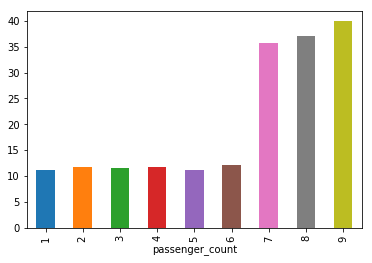

In [37]:
train.select('passenger_count', 'fare_amount').groupby('passenger_count').agg(F.mean('fare_amount')).sort('passenger_count')\
.toPandas().plot.bar('passenger_count', 'avg(fare_amount)',legend=False)
plt.show()

In [38]:
# FInd whch is a taxi and whoch a van
def taxi_or_van(df):
    
    df = df.withColumn('taxi_or_van', F.when( (col('passenger_count') <= 6), 'taxi')\
                      .otherwise('van'))
    return df

In [39]:
# Add taxi vs van variable to df:

train = taxi_or_van(train)

#### 4) Fare AMount

Checking the statistics, it is clear that some values are not possible, I am going to remove negatives values and all values that are lower that 2.50 dollars (https://nymag.com/nymetro/urban/features/taxi/n_20286/). Hence, I will keep all values greather than 2.50 dollars. For what concerns the maximum it is difficult to think about a joutney in taxi for a price of 93963$. The median instead is around 325$, which is a more reasonable value. It is clear that the distribution is right skewed (mean < median) and in addition the values over the median are only 134 and looking for some of their attributes it seems that there is no real reasons to have so huge fare amount. Given that I suppose that the most of them are outlayers, therefore I am going to drop anything over the median. Furthermore, considering the high skew, it may be reasonable to drop somenthing more, too.


In [40]:
# Get statistics:
train.select('fare_amount').describe().toPandas()

,summary,fare_amount
0,count,54044321
1,mean,11.33294135419023
2,stddev,20.86706348406584
3,min,-300.0
4,max,93963.36


In [41]:
# Remove Values lower than 2.50$:
train = train.filter('fare_amount > 2.50')

In [47]:
# Compute Quantiles:
fair_quantiles= train.approxQuantile('fare_amount', [0.25, 0.50, 0.75], 0.25)
fair_quantiles

[2.51, 375.0, 93963.36]

In [56]:
# Check some values over the median
print('Obs over the median: {:d}'.format(train.filter('fare_amount > 375').count()))
train.filter('fare_amount>375').select('fare_amount','haversine_dist', 'direction','airport','passenger_count','taxi_or_van').show(10)

Obs over the median: 134
+-----------+--------------+------------------+----------+---------------+-----------+
|fare_amount|haversine_dist|         direction|   airport|passenger_count|taxi_or_van|
+-----------+--------------+------------------+----------+---------------+-----------+
|      400.0|           0.0|             180.0|NO_AIRPORT|              1|       taxi|
|      499.0|         0.012|324.26197795325294|NO_AIRPORT|              1|       taxi|
|      475.0|         0.001|             180.0|NO_AIRPORT|              1|       taxi|
|      450.0|         0.001| 4.396683387821781|NO_AIRPORT|              1|       taxi|
|     377.75|        84.095| 52.57840168530231|  PICK_LGR|              1|       taxi|
|      440.0|           0.0| 44.98473111992348|NO_AIRPORT|              1|       taxi|
|     444.44|           0.0| 90.00000821723745|NO_AIRPORT|              1|       taxi|
|      400.0|           0.0|               0.0|NO_AIRPORT|              1|       taxi|
|      450.0|     

In [64]:
# Remove Outlayers:
train = train.filter('fare_amount < 325')

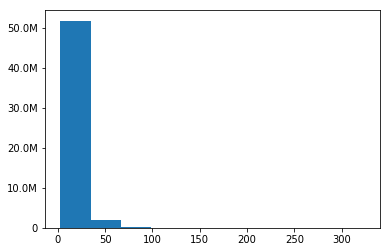

In [69]:
fig, ax = plt.subplots(1,1)
hist(ax, train.select('fare_amount'), bins=10)
plt.show()

In [ ]:
# Save new df for the dashboard:
print('Start Create Csv:')
s = time()
to_csv = train.select('fare_amount','pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude', 'haversine_dist', 'direction',
             'airport', 'long_short', 'passenger_count', 'taxi_or_van','is_week_end','part_of_day')
to_csv = to_csv.sample(fraction=0.02, seed=123)
to_csv.coalesce(1).write.format("csv").option('header', 'true').save(PATH_BUCKET+'new_train')
print('End creation in {:.2f} minutess'.format( (time()-s)/60 ))

Start Create Csv:
